In [2]:
# to print all output for a cell instead of only last one 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# IMPORTS 

from pathlib import Path 
import os 

import pandas as pd
import numpy as np
from collections import OrderedDict, namedtuple

import wandb 
from datetime import datetime
import pytz 

In [4]:
# PATHS 
BASE_PATH = Path(*Path().absolute().parts[:-1])
DATA_FOLDER = BASE_PATH / 'data' # directory containing the notebook

Load data


In [211]:
import json 

json_file_path_train = DATA_FOLDER / 'Twibot-20/train.json'
json_file_path_val = DATA_FOLDER / 'Twibot-20/dev.json'
json_file_path_test = DATA_FOLDER / 'Twibot-20/test.json'

with open(json_file_path_train, 'r') as tr:
     contents = json.loads(tr.read())
     train_df = pd.json_normalize(contents)
     train_df['split'] = 'train'

with open(json_file_path_val, 'r') as vl:
     contents = json.loads(vl.read())
     val_df = pd.json_normalize(contents) 
     val_df['split'] = 'val'

with open(json_file_path_test, 'r') as ts:
     contents = json.loads(ts.read())
     test_df = pd.json_normalize(contents) 
     test_df['split'] = 'test'

df = pd.concat([train_df,val_df,test_df],ignore_index=True) # merge three datasets
df.dropna(subset=['tweet'], inplace=True)  # remove rows without any tweet 
df.set_index(keys='ID',inplace=True) # reset index

# split dataframe in two : tweet and account data 
tweets_df = df[['tweet','label','split']].reset_index()
tweets_df = tweets_df.explode('tweet').reset_index(drop=True)
tweets_df.rename(columns={"ID": "account_id"}, inplace=True)

account_df = df.drop('tweet',axis=1).reset_index()
account_df.rename(columns={"ID": "account_id"}, inplace=True)


In [212]:
account_df

,account_id,neighbor,domain,label,profile.id,profile.id_str,profile.name,profile.screen_name,profile.location,profile.profile_location,...,profile.profile_sidebar_border_color,profile.profile_sidebar_fill_color,profile.profile_text_color,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image,neighbor.following,neighbor.follower,split
0,17461978,NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,"Orlando, FL","{'id': '55b4f9e5c516e0b6', 'url': 'https://api...",...,181A1E,252429,666666,True,False,False,False,NaN,NaN,train
1,17685258,NaN,"[Politics, Entertainment, Sports]",0,17685258,17685258,Brad Parscale,parscale,Florida,None,...,FFFFFF,FFFFFF,666666,False,False,False,False,"[46464108, 21536398, 18643437, 589490020, 1363...","[1275068515666386945, 2535843469, 129365759103...",train
2,15750898,NaN,[Politics],0,15750898,15750898,FOX 13 Tampa Bay,FOX13News,"Tampa, FL",None,...,FFFFFF,E8EEF0,333333,True,False,False,False,"[2324715174, 24030137, 2336676015, 192684124, ...","[855194021458739200, 1267566832598290432, 1290...",train
3,1659167666,NaN,[Politics],1,1659167666,1659167666,Vonte The Plug 🎤🔌,VonteThePlugNC,"Jacksonville Beach, FL","{'id': '5e281c17a74c170f', 'url': 'https://api...",...,C0DEED,DDEEF6,333333,True,False,True,False,"[1628313708, 726405625, 130868956, 26652768, 3...","[893137540185718785, 1063858543, 26665819, 241...",train
4,34743251,NaN,"[Politics, Business, Entertainment, Sports]",0,34743251,34743251,SpaceX,SpaceX,"Hawthorne, CA",None,...,FFFFFF,EFEFEF,333333,True,False,False,False,NaN,NaN,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11741,452754350,NaN,[Sports],1,452754350,452754350,Alan Reifman,AlanReifman,"Lubbock, Texas",None,...,FFFFFF,DDEEF6,333333,True,False,False,False,"[2924422992, 2365623499, 3383893516, 304921770...","[2308703630, 230020648, 20673104, 818336445102...",test
11742,850435801687183362,NaN,[Sports],1,850435801687183362,850435801687183362,Junk Wax Investment Services ($19.99 Per Month),CardsFromAttic,JunkWaxSylvania,None,...,C0DEED,DDEEF6,333333,True,False,True,False,"[704144006129692674, 953363306244227072, 84551...","[333490198, 905966469929979904, 12875470492238...",test
11743,2188795745,NaN,[Sports],1,2188795745,2188795745,B,bkgreen09,United States,None,...,000000,000000,000000,False,True,False,False,"[66762778, 2981733093, 186186153, 198600462, 7...","[249907794, 4843189571, 694904945393426432, 29...",test
11744,940687680,NaN,[Sports],1,940687680,940687680,bilal koç,bilalko14,,None,...,C0DEED,DDEEF6,333333,True,False,True,False,"[559791853, 1008065499136249856, 107059213, 36...","[942435278, 280899355, 1262431498751184896, 13...",test


In [213]:
print(account_df.columns.to_list())

['account_id', 'neighbor', 'domain', 'label', 'profile.id', 'profile.id_str', 'profile.name', 'profile.screen_name', 'profile.location', 'profile.profile_location', 'profile.description', 'profile.url', 'profile.entities', 'profile.protected', 'profile.followers_count', 'profile.friends_count', 'profile.listed_count', 'profile.created_at', 'profile.favourites_count', 'profile.utc_offset', 'profile.time_zone', 'profile.geo_enabled', 'profile.verified', 'profile.statuses_count', 'profile.lang', 'profile.contributors_enabled', 'profile.is_translator', 'profile.is_translation_enabled', 'profile.profile_background_color', 'profile.profile_background_image_url', 'profile.profile_background_image_url_https', 'profile.profile_background_tile', 'profile.profile_image_url', 'profile.profile_image_url_https', 'profile.profile_link_color', 'profile.profile_sidebar_border_color', 'profile.profile_sidebar_fill_color', 'profile.profile_text_color', 'profile.profile_use_background_image', 'profile.has

In [214]:
to_drop = ['neighbor','domain','profile.id','profile.id_str','profile.profile_location','profile.entities','profile.utc_offset','profile.time_zone','profile.lang',
'profile.contributors_enabled','profile.is_translator','profile.is_translation_enabled','profile.profile_background_color','profile.profile_background_image_url','profile.profile_background_image_url_https',
'profile.profile_background_tile','profile.profile_image_url','profile.profile_image_url_https','profile.profile_link_color','profile.profile_sidebar_border_color','profile.profile_sidebar_fill_color',
'profile.profile_text_color','profile.has_extended_profile','neighbor.following', 'neighbor.follower']
account_df = account_df.drop(to_drop,axis=1).reset_index(drop=True)

In [215]:
print(account_df.columns.to_list())

['account_id', 'label', 'profile.name', 'profile.screen_name', 'profile.location', 'profile.description', 'profile.url', 'profile.protected', 'profile.followers_count', 'profile.friends_count', 'profile.listed_count', 'profile.created_at', 'profile.favourites_count', 'profile.geo_enabled', 'profile.verified', 'profile.statuses_count', 'profile.profile_use_background_image', 'profile.default_profile', 'profile.default_profile_image', 'split']


In [216]:
rename_dict = {'profile.name': 'name', 'profile.screen_name': 'screen_name', 'profile.location': 'location','profile.description':'description',
'profile.url' : 'url', 'profile.protected' : 'protected', 'profile.followers_count':'followers_count', 'profile.friends_count':'friends_count', 
'profile.listed_count':'listed_count','profile.created_at' :'created_at', 'profile.favourites_count' :'favourites_count','profile.geo_enabled':'geo_enabled',
'profile.verified':'verified', 'profile.statuses_count':'statuses_count','profile.profile_use_background_image' : 'background_image',
'profile.default_profile' : 'default_profile', 'profile.default_profile_image':'default_profile_image'}
account_df.rename(columns=rename_dict, inplace=True)

account_df = account_df.applymap(lambda x : x.rstrip())


In [217]:
print(account_df.columns.tolist())

['account_id', 'label', 'name', 'screen_name', 'location', 'description', 'url', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'geo_enabled', 'verified', 'statuses_count', 'background_image', 'default_profile', 'default_profile_image', 'split']


In [218]:
account_df

,account_id,label,name,screen_name,location,description,url,protected,followers_count,friends_count,listed_count,created_at,favourites_count,geo_enabled,verified,statuses_count,background_image,default_profile,default_profile_image,split
0,17461978,0,SHAQ,SHAQ,"Orlando, FL","VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",https://t.co/7hsiK8cCKW,False,15349596,692,45568,Tue Nov 18 10:27:25 +0000 2008,142,True,True,9798,True,False,False,train
1,17685258,0,Brad Parscale,parscale,Florida,Owner @ Parscale Strategy. Senior Advisor Digi...,https://t.co/GooZcYDqFg,False,762839,475,3201,Thu Nov 27 18:47:32 +0000 2008,953,True,True,5518,False,False,False,train
2,15750898,0,FOX 13 Tampa Bay,FOX13News,"Tampa, FL",Bringing you the important stuff like breaking...,https://t.co/RtP9QYEZCq,False,327587,4801,1744,Wed Aug 06 15:12:10 +0000 2008,2946,True,True,192876,True,False,False,train
3,1659167666,1,Vonte The Plug 🎤🔌,VonteThePlugNC,"Jacksonville Beach, FL",MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,https://t.co/5cY8GWvk8E,False,13324,647,44,Sat Aug 10 03:25:35 +0000 2013,729,False,False,103,True,True,False,train
4,34743251,0,SpaceX,SpaceX,"Hawthorne, CA","SpaceX designs, manufactures and launches the ...",https://t.co/SDnmlLwwoK,False,12601567,96,26952,Thu Apr 23 21:53:30 +0000 2009,177,False,True,4879,True,False,False,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11741,452754350,1,Alan Reifman,AlanReifman,"Lubbock, Texas",Texas Tech professor of human devt and family ...,http://t.co/vwXejeH3i0,False,7760,8104,106,Mon Jan 02 06:17:32 +0000 2012,75,False,False,2330,True,False,False,test
11742,850435801687183362,1,Junk Wax Investment Services ($19.99 Per Month),CardsFromAttic,JunkWaxSylvania,Satirizing the sports card industry one tweet ...,https://t.co/CzOhDBbE8U,False,8446,408,55,Fri Apr 07 19:51:10 +0000 2017,125825,False,False,50168,True,True,False,test
11743,2188795745,1,B,bkgreen09,United States,,None,False,309,1961,3,Wed Nov 20 12:36:56 +0000 2013,1572,True,False,2950,False,False,False,test
11744,940687680,1,bilal koç,bilalko14,,,None,False,154,1019,0,Sun Nov 11 06:42:25 +0000 2012,627,False,False,152,True,True,False,test


In [219]:
feature = "geo_enabled"


print(f"True -> {len(account_df[account_df[feature] =='True'])}")
print(f"True spazio -> {len(account_df[account_df[feature] =='True '])}")
print(f"False -> {len(account_df[account_df[feature] =='False'])}")
print(f"False spazio -> {len(account_df[account_df[feature] =='False '])}")
print(f"None -> {len(account_df[account_df[feature] =='None'])}")
print(f"None spazio -> {len(account_df[account_df[feature] =='None '])}")
print(f"None type-> {len(account_df[account_df[feature] == None])}")
print(f"Nan -> {len(account_df[account_df[feature].isna()])}")
print(f"Spazio -> {len(account_df[account_df[feature] ==' '])}")
print(f"Vuoto -> {len(account_df[account_df[feature] ==''])}")



True -> 4967
True spazio -> 0
False -> 6779
False spazio -> 0
None -> 0
None spazio -> 0
None type-> 0
Nan -> 0
Spazio -> 0
Vuoto -> 0


In [266]:
import re 
import collections
import math 
from datetime import datetime
import Levenshtein


def description_len(desc:str):
    if desc == "":
        return 0
    else : 
        return len(desc)

def fofo_ratio(f1: str ,f2: str):
    f1,f2 = int(f1), int(f2)
    if f2 == 0.0 : 
        return f1
    else : 
        return f1/f2 

def numbers_in_str(s : str):
    return len(re.findall(r'\d+', s))
        
def hashtag_in_str(s: str):
    return len(re.findall(r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)""",s))

def urls_in_str(s: str):
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', s)
    return len(urls)

def bot_world_in_str(s: str):
    return int(bool(re.search('bot', s, flags=re.IGNORECASE)))


def get_str_entropy(s : str):
    counter = collections.Counter(s)
    screen_name_entropy = 0
    for key, cnt in counter.items():
        prob = float(cnt) / len(s)
        screen_name_entropy += -1 * prob * math.log(prob, 2)
    return screen_name_entropy
    
def get_account_age(created_at : str) :
    Twibot_20_FORMAT = f'%a %b %d %H:%M:%S %z %Y'
    creation_date = datetime.strptime(created_at,Twibot_20_FORMAT).date()
    present_date = datetime.now().date()
    user_age = (present_date - creation_date).days
    return int(user_age)


def frequency(created_at : str, numerator : str):
    age = get_account_age(created_at)
    avg_tweets = int(numerator) / age 
    return avg_tweets

def lev_name_screenName(name : str, screen_name : str) :
    return Levenshtein.distance(name,screen_name)

In [362]:
feature_df = account_df[['account_id','label','split']].reset_index(drop=True)
feature_df['label'] = feature_df['label'].astype(int)


#KOUVELA 
#feature_df['has_desc'] = (account_df['description'] != '').astype(int)  #check lenght 1486
feature_df['has_location'] = (account_df['location'] != '').astype(int)  #check lenght 3386
feature_df['has_url'] = (account_df['url'] != 'None').astype(int)  #check lenght 5965
# feature_df['is_verified'] = (account_df['verified'] == 'True').astype(int)  #check lenght 2962
#feature_df['bot_word_in_name'] = account_df['name'].apply(bot_world_in_str)
#feature_df['bot_word_in_screen_name'] = account_df['screen_name'].apply(bot_world_in_str)
#feature_df['bot_word_in_description'] = account_df['description'].apply(bot_world_in_str)
feature_df['name_len'] = account_df['name'].apply(len)
feature_df['screen_name_len'] = account_df['screen_name'].apply(len)
feature_df['description_len'] = account_df['description'].apply(description_len)
feature_df['followings_count'] = account_df['friends_count'].astype(int)
feature_df['followers_count'] = account_df['followers_count'].astype(int)
feature_df['fofo_ratio'] = account_df.apply(lambda x: fofo_ratio(x['followers_count'], x['friends_count']), axis=1)
feature_df["tweets_count"] = account_df['statuses_count'].astype(int)
feature_df["listed_count"] = account_df['listed_count'].astype(int)
#feature_df["num_in_name"] = account_df['name'].apply(numbers_in_str)
feature_df["num_in_screen_name"] = account_df['screen_name'].apply(numbers_in_str)
feature_df['hashtag_in_description'] = account_df['description'].apply(hashtag_in_str)
#feature_df['urls_in_description'] = account_df['description'].apply(urls_in_str)
#feature_df['def_image'] = (account_df['default_profile_image'] == 'True').astype(int)
feature_df['def_profile'] = (account_df['default_profile'] == 'True').astype(int)

#KANTEPE 
#feature_df['is_protected'] = (account_df['protected'] == 'True').astype(int)
feature_df['screen_name_entropy'] = account_df['screen_name'].apply(get_str_entropy)
feature_df['tweet_freq'] = account_df.apply(lambda x: frequency(x['created_at'], x['statuses_count']), axis=1)

#KNAUTH
feature_df['is_geo_enabled'] = (account_df['geo_enabled'] == 'True').astype(int)
feature_df["favourites_count"] = account_df['favourites_count'].astype(int)
#feature_df['use_background_img'] = (account_df['background_image'] == 'True').astype(int)
feature_df['lev_dist_name_screeName'] = account_df.apply(lambda x: lev_name_screenName(x['name'], x['screen_name']), axis=1)

#SGBOT 
feature_df['followers_growth_rate'] = account_df.apply(lambda x: frequency(x['created_at'], x['followers_count']), axis=1)
feature_df['followings_growth_rate'] = account_df.apply(lambda x: frequency(x['created_at'], x['friends_count']), axis=1)
feature_df['favourites_growth_rate'] = account_df.apply(lambda x: frequency(x['created_at'], x['favourites_count']), axis=1)


In [363]:
feature_df

,account_id,label,split,has_location,has_url,is_verified,name_len,screen_name_len,description_len,followings_count,...,hashtag_in_description,def_profile,screen_name_entropy,tweet_freq,is_geo_enabled,favourites_count,lev_dist_name_screeName,followers_growth_rate,followings_growth_rate,favourites_growth_rate
0,17461978,0,train,1,1,1,4,4,50,692,...,0,0,2.000000,1.934452,1,142,0,3030.522409,0.136624,0.028036
1,17685258,0,train,1,1,1,13,8,160,475,...,0,0,2.750000,1.091377,1,953,6,150.877967,0.093948,0.188489
2,15750898,0,train,1,1,1,16,9,160,4801,...,0,0,3.169925,37.313987,1,2946,11,63.375314,0.928806,0.569936
3,1659167666,1,train,1,1,0,17,14,103,647,...,0,1,3.664498,0.030848,0,729,5,3.990416,0.193771,0.218329
4,34743251,0,train,1,1,1,6,6,90,96,...,0,0,2.584963,0.993889,0,177,0,2567.033408,0.019556,0.036056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11741,452754350,1,test,1,1,0,12,11,152,8104,...,0,0,3.095795,0.593631,0,75,1,1.977070,2.064713,0.019108
11742,850435801687183362,1,test,1,1,0,47,14,143,408,...,7,1,3.521641,25.046430,0,125825,42,4.216675,0.203694,62.818273
11743,2188795745,1,test,1,0,0,1,9,0,1961,...,0,0,2.947703,0.911338,1,1572,9,0.095459,0.605808,0.485635
11744,940687680,1,test,0,0,0,9,9,0,1019,...,0,1,2.947703,0.042094,0,627,3,0.042647,0.282193,0.173636


In [364]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train = feature_df[feature_df['split'] == 'train'].reset_index(drop=True)
val = feature_df[feature_df['split'] == 'val'].reset_index(drop=True)
test = feature_df[feature_df['split'] == 'test'].reset_index(drop=True)

X_train, y_train = train.drop(columns=["account_id", "label", "split"], axis=1), train["label"]
X_val, y_val = val.drop(columns=["account_id", "label", "split"], axis=1), val["label"]
X_test, y_test = test.drop(columns=["account_id", "label", "split"], axis=1), test["label"]


In [365]:
X_train

,has_location,has_url,is_verified,name_len,screen_name_len,description_len,followings_count,followers_count,fofo_ratio,tweets_count,...,hashtag_in_description,def_profile,screen_name_entropy,tweet_freq,is_geo_enabled,favourites_count,lev_dist_name_screeName,followers_growth_rate,followings_growth_rate,favourites_growth_rate
0,1,1,1,4,4,50,692,15349596,22181.497110,9798,...,0,0,2.000000,1.934452,1,142,0,3030.522409,0.136624,0.028036
1,1,1,1,13,8,160,475,762839,1605.976842,5518,...,0,0,2.750000,1.091377,1,953,6,150.877967,0.093948,0.188489
2,1,1,1,16,9,160,4801,327587,68.233076,192876,...,0,0,3.169925,37.313987,1,2946,11,63.375314,0.928806,0.569936
3,1,1,0,17,14,103,647,13324,20.593509,103,...,0,1,3.664498,0.030848,0,729,5,3.990416,0.193771,0.218329
4,1,1,1,6,6,90,96,12601567,131266.322917,4879,...,0,0,2.584963,0.993889,0,177,0,2567.033408,0.019556,0.036056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8218,0,0,1,11,13,160,821,10997,13.394641,25790,...,0,1,3.546594,7.696210,0,20115,4,3.281707,0.245001,6.002686
8219,0,0,0,12,13,157,637,44,0.069074,425,...,0,1,2.931209,0.178571,0,298,12,0.018487,0.267647,0.125210
8220,1,0,0,15,14,133,849,342,0.402827,1439,...,3,1,3.182006,0.306888,0,2464,1,0.072937,0.181062,0.525485
8221,1,0,0,7,8,65,367,72,0.196185,674,...,0,1,2.750000,0.203564,0,2634,8,0.021746,0.110843,0.795530


In [366]:
a = X_train[X_train['is_verified'] == 0]
b = X_train[X_train['is_verified'] == 1]


c = len(X_train)


d1= len(a[y_train == 0])
d2= len(b[y_train == 0])
d3= len(a[y_train == 1])
d4= len(b[y_train == 1])

print(f'non verificati e non bot -> tot : {d1}, perc : {(d1/c)*100}%')
print(f'verificati e non bot -> tot : {d2}, perc : {(d2/c)*100}%')
print(f'non verificati e bot -> tot : {d3}, perc : {(d3/c)*100}%')
print(f'verificati e bot -> tot : {d4}, perc : {(d4/c)*100}%')



non verificati e non bot -> tot : 1538, perc : 18.70363614252706%
verificati e non bot -> tot : 2054, perc : 24.978718229356684%
non verificati e bot -> tot : 4630, perc : 56.30548461632008%
verificati e bot -> tot : 1, perc : 0.012161011796181443%


C:\Users\Riccardo\AppData\Local\Temp\ipykernel_23128\2552238175.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d1= len(a[y_train == 0])
C:\Users\Riccardo\AppData\Local\Temp\ipykernel_23128\2552238175.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d2= len(b[y_train == 0])
C:\Users\Riccardo\AppData\Local\Temp\ipykernel_23128\2552238175.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d3= len(a[y_train == 1])
C:\Users\Riccardo\AppData\Local\Temp\ipykernel_23128\2552238175.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d4= len(b[y_train == 1])


In [367]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=18)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print('acc:', acc)
print('precision:', precision)
print('recall:', recall)
print('f1score:', f1score)

RandomForestClassifier(class_weight='balanced', random_state=18)

acc: 0.8218243819266837
precision: 0.7600979192166463
recall: 0.9794952681388013
f1score: 0.8559614059269469


In [368]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=18)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print('acc:', acc)
print('precision:', precision)
print('recall:', recall)
print('f1score:', f1score)

DecisionTreeClassifier(random_state=18)

acc: 0.7433930093776641
precision: 0.7779632721202003
recall: 0.7350157728706624
f1score: 0.7558799675587997


In [369]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, random_state=18)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print('acc:', acc)
print('precision:', precision)
print('recall:', recall)
print('f1score:', f1score)

GradientBoostingClassifier(random_state=18)

acc: 0.8209718670076727
precision: 0.7572815533980582
recall: 0.9842271293375394
f1score: 0.8559670781893004


<Figure size 720x1080 with 0 Axes>

<BarContainer object of 31 artists>

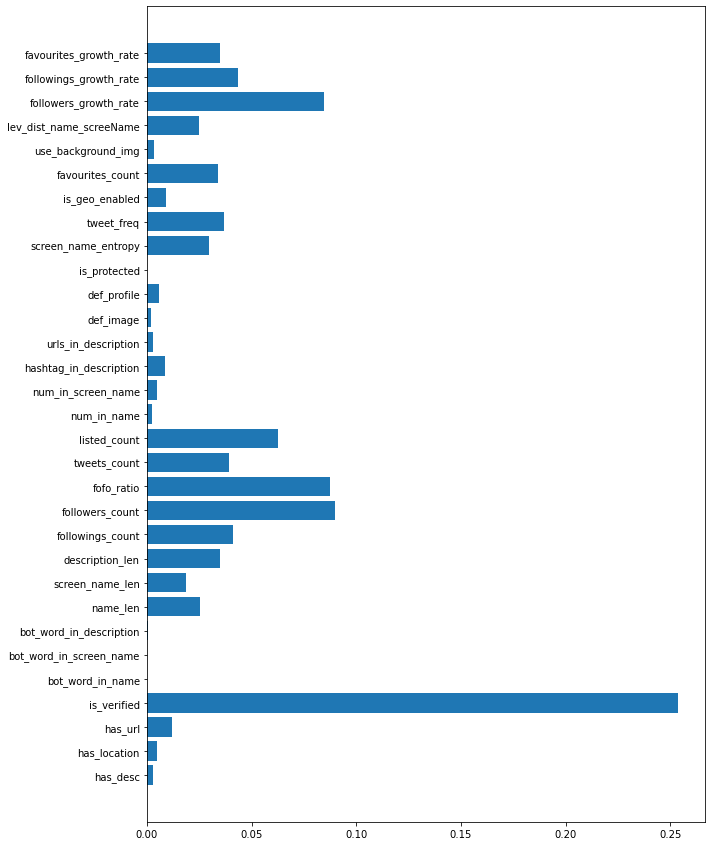

In [265]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,15))
plt.barh(X_train.columns,rf.feature_importances_)


In [41]:
a = len(y_test[y_test == 0])
b = len(y_test[y_test == 1])
c = len(y_test)

a/c

b/c


0.4595055413469736

0.5404944586530265

DATA PROCESSING AND CLEANING  

In [ ]:
import emoji
from nltk.tokenize import TweetTokenizer
#from langdetect import detect

from ttp import ttp 
parser = ttp.Parser(include_spans=True)

from emot.core import emot
emot_obj = emot()

import re 

tk = TweetTokenizer(reduce_len=True,preserve_case=False)

RETWEET = r"^RT (?:@[\w_]+):"
NEWLINE = r"\n"
CASHTAG = r"(?<!\S)\$[A-Z]+(?:\.[A-Z]+)?(?!\S)"
EMAIL = r"""[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]"""
MONEY = r"[$£][0-9]+(?:[.,]\d+)?[Kk+BM]?|[0-9]+(?:[.,]\d+)?[Kk+BM]?[$£]"
NUMBER = r"""(?<!\S)(?:[+\-]?\d+(?:%|(?:[,/.:-]\d+[+\-]?)?))"""
HASHTAG = r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
HANDLE = r"""(?:@[\w_]+)"""

TO_REPLACE = [RETWEET, NEWLINE, CASHTAG, EMAIL, MONEY, NUMBER, HASHTAG, HANDLE]
REPLACE_WITH = [' retweet ',' ',' stock ',' email ',' money ',' number ',' hashtag ',' username ']


def replace(word : str):
    # if not word.isascii():
    #     return ['']
    if bool(re.search(r'http[s]?|.com',word)):
        return ['url']
    elif bool(re.search(r'\d',word)):
        return ['number']
    elif bool(re.search(r'haha|ahah|jaja|ajaj',word)):
        return ['ahah']
    elif bool(re.search(r'\n',word)):
        return ['']
    elif bool(re.search('-',word)):
        return re.sub('-',' ',word).split()
    elif bool(re.search("'",word)):
        return re.sub("'"," '",word).split()     #CHANGE ? 
    else :
        return [word] 
    

def further_process(sentence: str):

    #remove non-english sentences
    # try:
    #     if detect(sentence) != 'en': 
    #         return ''
    # except:
    #     return ''

    #replace urls 
    result = parser.parse(sentence, html=False)
    urls = dict(result.urls).keys()
    for url in urls:
        sentence = sentence.replace(url,' url ')
    
    #replace emoticons 
    emoticons = emot_obj.emoticons(sentence)
    for emoticon in emoticons['value']:
        sentence = sentence.replace(emoticon,' emoticon ')
    
    #replace emoji
    sentence = emoji.replace_emoji(sentence,' emoji ')

    #tokenize
    sentence = tk.tokenize(sentence)

    #replace residual wrong words 
    sentence = [w for word in sentence for w in replace(word)]
    
    #remove empty strings 
    sentence = [word for word in sentence if word != '']
            
    return sentence

dataset_path = DATA_FOLDER / 'processed_dataset_v1.pkl'
force_processing = False

#apply preprocessing      
if os.path.exists(dataset_path) and not force_processing: 
    print('found already processed dataset in data folder, retrieving the file...')
    tweets_df = pd.read_pickle(dataset_path)
    print('dataset loaded in Dataframe')
    
else : 
    tweets_df['processed_tweet'] = tweets_df['tweet'].replace(TO_REPLACE,REPLACE_WITH,regex=True,inplace=False)
    tweets_df['processed_tweet'] = tweets_df['processed_tweet'].apply(further_process)

    #tweets_df = tweets_df[tweets_df['processed_tweet'].map(lambda x: len(x)) > 2].reset_index(drop=True)   #TODO CHECK  

    tweets_df['label'] = tweets_df['label'].astype(float)  #TODO CHECK   # transform label from string to float 

    tweets_df.to_pickle(dataset_path)   #save to file 


DOWNLOAD TWITTER GLOVE EMBEDDINGS

In [ ]:
import gensim
import gensim.downloader as gloader
from gensim.models import KeyedVectors
import gdown 

emb_model_cached_path = DATA_FOLDER / "twitter-multilingual-300d.new.bin" #'glove_vectors.txt'
emb_model_download_path = "twitter-multilingual-300d.new.bin" #'glove-twitter-200'
force_download = False  # to download glove model even if the vectors model has been already stored. Mainly for testing purposes
id_model = "1DprdHGocFXJ9swnb2pDJJxHw5QR810LS"

if not os.path.exists(emb_model_cached_path) and force_download: 
    print('downloading embedding model...')        
    gdown.download(id=id_model,output=str(emb_model_cached_path))
else : 
    print('found cached glove vectors in data folder, retrieving the file...')

emb_model = KeyedVectors.load_word2vec_format(emb_model_cached_path, binary=True)
print('vectors loaded')

In [ ]:
emb_model.most_similar('cashtag')

CUSTOM DATA HANDLING  

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn
import torch 

Vocab = namedtuple('Vocabulary',['word2int','int2word','unique_words'])

class TwitterDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame):
        self.tweet = dataframe['processed_tweet']
        self.label = dataframe['label']

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return {
            'tweet': self.tweet[idx],
            'label': self.label[idx],
            }

class TwitterDataManager():

    def __init__(self, dataframe : pd.DataFrame, device ):

        self.device = device 

        self.dataset = dataframe.copy(deep=True)
        self.train_ds = TwitterDataset(self.dataset[self.dataset['split'] == 'train'].reset_index(drop=True))
        self.val_ds = TwitterDataset(self.dataset[self.dataset['split'] == 'val'].reset_index(drop=True))
        self.test_ds = TwitterDataset(self.dataset[self.dataset['split'] == 'test'].reset_index(drop=True))

    def custom_collate(self, batch):
        
        tweet_lengths = torch.tensor([len(example['tweet']) for example in batch]) #, device=self.device -> for pack_padded should be on cpu so if only used by that don't put it on gpu

        numerized_tweets = [self.numericalize(example['tweet']) for example in batch]
        padded_tweets = rnn.pad_sequence(numerized_tweets, batch_first = True, padding_value = self.vocab.word2int['<pad>']).to(self.device)

        labels = torch.tensor([example['label'] for example in batch],device=self.device) #(5)

        return {
            'tweets': padded_tweets,
            'labels': labels,
            'lengths': tweet_lengths
        }
    
    def numericalize(self, token_list):  

        assert self.vocab is not None, "you have to build the vocab first, call build_vocab method to do it"
        return torch.tensor(list(map(self.vocab.word2int.get,token_list)))
    
    def build_vocab(self): 
        print('Building vocab...')

        unique_words : list = self.dataset['processed_tweet'].explode().unique().tolist()
        unique_words.insert(0,'<pad>')

        word2int = OrderedDict()
        int2word = OrderedDict()

        for i, word in enumerate(unique_words):
            word2int[word] = i           
            int2word[i] = word
        
        self.vocab = Vocab(word2int,int2word,unique_words)

        print(f'the number of unique words is {len(unique_words)}')
    
    def build_emb_matrix(self, emb_model): 
        print('Building embedding matrix...')

        embedding_dimension = emb_model.vector_size #how many numbers each emb vector is composed of                                                           
        embedding_matrix = np.zeros((len(self.vocab.word2int)+1, embedding_dimension), dtype=np.float32)   #create a matrix initialized with all zeros 

        for word, idx in self.vocab.word2int.items():
            if idx == 0: continue
            try:
                embedding_vector = emb_model[word]
            except (KeyError, TypeError):
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

            embedding_matrix[idx] = embedding_vector     #assign the retrived or the generated vector to the corresponding index 
        
        self.emb_matrix = embedding_matrix
        
        print(f"Embedding matrix shape: {embedding_matrix.shape}")
    
    def getDataloader(self, split : str, batch_size : int, shuffle : bool):

        dataset = getattr(self,split+'_ds') 
        return DataLoader(dataset,batch_size,shuffle=shuffle,collate_fn=self.custom_collate)

In [ ]:
import random 
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, unique_words, type : str):
    """
        Given the embedding model and the unique words in the dataframe, determines the out-of-vocabulary words 
    """
    oov_words = []

    if embedding_model is None:
        print('WARNING: empty embeddings model')

    else: 
        for word in unique_words:
            try: 
                embedding_model[word]
            except:
                oov_words.append(word) 
        
        print(f"Number of unique words in {type} dataset:",len(unique_words))
        print("Total OOV terms: {0} which is ({1:.2f}%)".format(len(oov_words), (float(len(oov_words)) / len(unique_words))*100))
        print("Some OOV terms:",random.sample(oov_words,10))
    
    return oov_words

train = tweets_df[tweets_df['split']=='train']
val = tweets_df[tweets_df['split']=='val']
test = tweets_df[tweets_df['split']=='test']

uw_train : list = train['processed_tweet'].explode().unique().tolist()
uw_val : list = val['processed_tweet'].explode().unique().tolist()
uw_test : list = test['processed_tweet'].explode().unique().tolist()
uw_all : list = tweets_df['processed_tweet'].explode().unique().tolist()

a = check_OOV_terms(emb_model,uw_train,'train')
b = check_OOV_terms(emb_model,uw_val,'val')
c = check_OOV_terms(emb_model,uw_test,'test')
d = check_OOV_terms(emb_model,uw_all,'all')

MODEL : SINGLE TWEET NETWORK 

In [ ]:
#pytorch imports

import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.utils.rnn as rnn
import torch.nn.functional as F

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


In [ ]:
class SingleTweet_model(nn.Module):
    
    def __init__(self, emb_matrix: np.ndarray, cfg : dict, device) :
        super().__init__()

        self.cfg = cfg
        self.device = device 

        self.embedding_layer, self.word_embedding_dim = self.build_emb_layer(emb_matrix,cfg['pad_idx'], cfg['freeze_embedding'])

        self.lstm = nn.LSTM(self.word_embedding_dim, cfg['hidden_dim'], num_layers = cfg['num_layers'], batch_first = True, bidirectional = True) 
            
        self.dropout = nn.Dropout(cfg['dropout_p']) 

        self.compress = nn.Linear(cfg['hidden_dim']*2,cfg['hidden_dim'])

        self.classifier = nn.Linear(cfg['hidden_dim'],1)   
    
    def name(self):
        return 'SingleTweet_model'

    def build_emb_layer(self, weights_matrix: np.ndarray, pad_idx : int, freeze : bool):
    
        matrix = torch.from_numpy(weights_matrix).to(self.device)   #the embedding matrix 
        _ , embedding_dim = matrix.shape 

        emb_layer = nn.Embedding.from_pretrained(matrix, freeze=freeze, padding_idx = pad_idx)   #load pretrained weights in the layer and make it non-trainable (TODO: trainable ? )
        
        return emb_layer, embedding_dim
        

    def forward(self, batch_data):
    
        tweets = batch_data['tweets']           # [batch_size, num_tokens]
        tweet_lengths = batch_data['lengths']   # [batch_size]

        #embed each word in a sentence with a n-dim vector 
        word_emb_tweets = self.embedding_layer(tweets)  # word_emb_tweets = [batch_size, num_tokens, embedding_dim]

        #pass the embedded tokens throught lstm network 
        packed_embeddings = pack_padded_sequence(word_emb_tweets, tweet_lengths, batch_first=True, enforce_sorted=False) #tweet_lengths.cpu() TODO
        output, (hn,cn)  = self.lstm(packed_embeddings)   # hn = [2, batch_size, embedding_dim]
        
        #concat forward and backward output
        fwbw_hn = torch.cat((hn[-1,:,:],hn[-2,:,:]),dim=1)  # fwbw_hn = [batch_size, 2*embedding_dim]
        
        #compress the output 
        compressed_out = self.compress(fwbw_hn) # compressed_out = [batch_size, embedding_dim]

        #apply non linearity
        compressed_out = F.relu(compressed_out)

        #eventual dropout 
        if self.cfg['dropout']: out = self.dropout(compressed_out)

        #final classification 
        predictions = self.classifier(out) #predictions [batch_size, 1]

        return predictions

In [ ]:
import time
from tkinter import Y 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm

#compute accuracy and f1-score 
def metrics(y_true, y_pred):
    """
        Compute accuracy and f1-score for an epoch 
    """
    acc = accuracy_score(y_true, y_pred)

    f1 = f1_score(y_true,y_pred,average='macro')

    prec = precision_score(y_true,y_pred,average='macro')

    rec = recall_score(y_true,y_pred,average="macro")

    return acc, f1, prec, rec

class Trainer():

    def __init__(self, model : nn.Module, device, criterion, optimizer) : #TODO qualcosa 
        
        self.device = device 

        model.to(self.device)
        self.model = model

        self.criterion = criterion.to(self.device) if isinstance(criterion, nn.Module) else criterion 
        self.optimizer = optimizer

        self.models_dir = BASE_PATH / 'models'


    def train_loop(self, dataloader : DataLoader):

        batch_size = dataloader.batch_size
        dataset_size = len(dataloader.dataset)

        start_time = time.perf_counter()

        tot_loss = 0
        
        #aggregate all the predictions and corresponding true labels (and claim ids) in tensors 
        all_pred , all_targ = np.empty(dataset_size), np.empty(dataset_size)

        self.model.train()
    
        for batch_id, batch_data in enumerate(tqdm(dataloader)):

            self.optimizer.zero_grad()            

            predictions : Tensor = self.model(batch_data)   #generate predictions 
            predictions = predictions.squeeze(1)

            loss = self.criterion(predictions, batch_data['labels'])      #compute the loss 

            #backward pass 
            loss.backward()
            self.optimizer.step()

            pred = (predictions > 0.0 ).detach().int().cpu().numpy()           #get class label 

            start = batch_id * batch_size
            end = start + batch_size

            #concatenate the new tensors with the one computed in previous steps
            all_pred[start:end] = pred 
            all_targ[start:end] = batch_data['labels'].detach().cpu().numpy()       

            tot_loss += loss.item()    #accumulate batch loss 


        acc, f1, prec, rec = metrics(all_targ,all_pred)

        loss = tot_loss/(batch_id+1)    #mean loss 

        end_time = time.perf_counter()

        return loss, acc, f1, prec, rec, end_time-start_time


    def eval_loop(self, dataloader : DataLoader):

        batch_size = dataloader.batch_size
        dataset_size = len(dataloader.dataset)

        start_time = time.perf_counter()

        tot_loss = 0
        
        #aggregate all the predictions and corresponding true labels (and claim ids) in tensors 
        all_pred , all_targ = np.empty(dataset_size), np.empty(dataset_size)
        
        self.model.eval()   #model in eval mode 
        
        with torch.no_grad(): #without computing gradients since it is evaluation loop
        
            for batch_id, batch_data in enumerate(tqdm(dataloader)):
                
                predictions : Tensor = self.model(batch_data)   #generate predictions 
                predictions = predictions.squeeze(1)

                loss = self.criterion(predictions, batch_data['labels'])      #compute the loss 

                pred = (predictions > 0.0 ).detach().int().cpu().numpy()        #get class label 
                start = batch_id * batch_size
                end = start + batch_size

                #concatenate the new tensors with the one computed in previous steps
                all_pred[start:end] = pred 
                all_targ[start:end] = batch_data['labels'].detach().cpu().numpy()     

                tot_loss += loss.item()   #accumulate batch loss 
                
        acc, f1, prec, rec = metrics(all_targ,all_pred)

        loss = tot_loss/(batch_id+1)   #mean loss 

        end_time = time.perf_counter()

        return loss, acc, f1, prec, rec, end_time-start_time

    
    def train_and_eval(self, train_loader, val_loader, num_epochs):
        """
            Runs the train and eval loop and keeps track of all the metrics of the training model 
        """
        best_f1 = -1   #init best f1 score

        for epoch in range(1, num_epochs+1): #epoch loop

            start_time = time.perf_counter()

            print(f'Starting epoch {epoch}')

            train_metrics = self.train_loop(train_loader) 
            val_metrics = self.eval_loop(val_loader) 
            
            end_time = time.perf_counter()

            tot_epoch_time = end_time-start_time          

            train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_prec, train_epoch_rec, train_epoch_time = train_metrics
            val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_prec, val_epoch_rec, val_epoch_time = val_metrics

            if val_epoch_f1 >= best_f1:
                best_f1 = val_epoch_f1
                if not os.path.exists(self.models_dir):        
                    os.makedirs(self.models_dir)
                torch.save(self.model.state_dict(),self.models_dir/ f'{self.model.name()}.pt')  

            # wandb logs 
            wandb.log({'train/loss': train_epoch_loss, 'train/acc': train_epoch_acc, 'train/f1': train_epoch_f1,
                       'train/prec': train_epoch_prec, 'train/rec': train_epoch_rec, 'train/time': train_epoch_time,
                       'val/loss': val_epoch_loss, 'val/acc': val_epoch_acc, 'val/f1': val_epoch_f1,
                       'val/prec': val_epoch_prec, 'val/rec': val_epoch_rec, 'val/time' : val_epoch_time, 
                       'lr': self.optimizer.param_groups[0]['lr'], 'epoch': epoch})
        
            print(f'Total epoch Time: {tot_epoch_time:.4f}')
            print(f'Train Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.2f}% | Train F1: {train_epoch_f1:.2f}')
            print(f'Val. Loss: {val_epoch_loss:.3f} | Val. Acc: {val_epoch_acc*100:.2f}% | Val. F1: {val_epoch_f1:.2f}')
    
    def test(self, test_loader):

        self.model.load_state_dict(torch.load(f'models/{self.model.name()}.pt'))

        self.eval_loop(test_loader)
        
        

Single Tweet Model Train Routine 

In [ ]:
#PARAMETERS, HYPERPARAMETERS AND USEFUL OBJECTS 

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'running on {DEVICE}')

#hyperparameters
BATCH_SIZE = 512                # number of sentences in each mini-batch
LR = 1e-3                       # learning rate 
NUM_EPOCHS = 5                  # number of epochs
WEIGHT_DECAY = 1e-5             # regularization
LSTM_HIDDEN_DIM = 300           # hidden dimension of lstm network 
LSTM_NUM_LAYERS = 1             # num of recurrent layers of lstm network 
FREEZE = False                  # wheter to make the embedding layer trainable or not              
DROPOUT = True                  # wheter to use dropout layer or not  
DROPOUT_P = 0.5                 # dropout probability
WANDB_MODE = 'disabled'

config = {
    'batch_size' : BATCH_SIZE,
    'lr' : LR,
    'num_epochs' : NUM_EPOCHS,
    'weight_decay' : WEIGHT_DECAY,
    'lstm_hidden_dim' : LSTM_HIDDEN_DIM,
    'lstm_num_layers': LSTM_NUM_LAYERS,
    'freeze' : FREEZE,
    'dropout' : DROPOUT,
    'dropout_p' : DROPOUT_P,
    'device' : DEVICE,
}

name = datetime.now(tz = pytz.timezone('Europe/Rome')).strftime("%d/%m/%Y %H:%M:%S") 
wandb.init(project="tweebot", entity="uniboland", name=name, config=config, mode=WANDB_MODE, tags=['singleTweetModel'], dir=str(BASE_PATH))

#to counteract class imbalance 
train = tweets_df[tweets_df['split']=='train']
(human, bot) = train['label'].value_counts()
weight_positive_class = torch.tensor([human/bot], device = DEVICE)  #weight to give to positive class 

data_manager = TwitterDataManager(tweets_df,DEVICE)
data_manager.build_vocab()
data_manager.build_emb_matrix(emb_model)

# model config parameters dictionary
model_cfg = {
    'pad_idx' : data_manager.vocab.word2int['<pad>'],
    'freeze_embedding' : FREEZE,  
    'dropout' : DROPOUT,
    'dropout_p' : DROPOUT_P,
    'hidden_dim' : LSTM_HIDDEN_DIM,
    'num_layers': LSTM_NUM_LAYERS
}

model = SingleTweet_model(data_manager.emb_matrix,model_cfg,DEVICE)

# criterion = nn.BCEWithLogitsLoss(pos_weight=param['weight_positive_class']).to(device)    #Binary CrossEntropy Loss that accept raw input and apply internally the sigmoid 
criterion = nn.BCEWithLogitsLoss(pos_weight=weight_positive_class)    #Binary CrossEntropy Loss that accept raw input and apply internally the sigmoid 
optimizer = optim.Adam(model.parameters(), lr=LR , weight_decay= WEIGHT_DECAY)   #L2 regularization 

train_loader = data_manager.getDataloader('train', BATCH_SIZE, True)
val_loader = data_manager.getDataloader('val', BATCH_SIZE, True)

trainer = Trainer(model, DEVICE, criterion, optimizer)
trainer.train_and_eval(train_loader, val_loader, NUM_EPOCHS)

wandb.finish()

TODO TEST MODEL AND LOG ON WANDB 

In [ ]:
wandb.finish()

SINGLE TWEET PLUS TEXT-BASED FEATURES 

In [ ]:
from string import punctuation
from nltk.corpus import stopwords
sw = stopwords.words('english')

df = tweets_df.copy(deep=True)  

def is_retweet(sentence_list : list):
    return float(sentence_list[0] == 'retweet')

def url_count(sentence_list : list):
    c = sentence_list.count('url')
    return c
    
def tag_count(sentence_list : list):
    c = sentence_list.count('username')
    return c

def hashtag_count(sentence_list : list):
    c = sentence_list.count('hashtag')
    return c

def cashtag_count(sentence_list : list):
    c = sentence_list.count('stock')
    return c

def money_count(sentence_list : list):
    c = sentence_list.count('money')
    return c

def email_count(sentence_list : list):
    c = sentence_list.count('email')
    return c
    
def number_count(sentence_list : list):
    c = sentence_list.count('number')
    return c

def emoticon_count(sentence_list : list):
    c = sentence_list.count('emoticon')
    return c

def emoji_count(sentence_list : list):
    c = sentence_list.count('emoji')
    return c

def stopwords_count(sentence_list : list):
    c = 0
    for word in sentence_list : 
        if word in sw:
            c+=1
        
    return c 

def punct_count(sentence_list : list):
    c = 0
    for word in sentence_list : 
        if word in punctuation:
            c+=1
        
    return c 

df['is_rt'] = df['processed_tweet'].apply(is_retweet)
df['url_c'] = df['processed_tweet'].apply(url_count)
df['tag_c'] = df['processed_tweet'].apply(tag_count)
df['hashtag_c'] = df['processed_tweet'].apply(hashtag_count)
df['cashtag_c'] = df['processed_tweet'].apply(cashtag_count)
df['money_c'] = df['processed_tweet'].apply(money_count)
df['email_c'] = df['processed_tweet'].apply(email_count)
df['number_c'] = df['processed_tweet'].apply(number_count)
df['emoji_c'] = df['processed_tweet'].apply(emoji_count)
df['emoticon_c'] = df['processed_tweet'].apply(emoticon_count)
df['len_tweet'] = df['processed_tweet'].apply(len)
df['stopwords_c'] = df['processed_tweet'].apply(stopwords_count)
df['punct_c'] = df['processed_tweet'].apply(punct_count)

In [ ]:
len(df['account_id'].unique())

In [ ]:
from scipy.stats import zscore 
column_names = ['url_c','tag_c','hashtag_c','cashtag_c','money_c','email_c','number_c','emoji_c','emoticon_c','len_tweet','stopwords_c','punct_c']

df[column_names] = df[column_names].apply(zscore)

df.head()

In [ ]:
column_names.append('is_rt')
df[column_names].corrwith(df['label'])

In [ ]:
tweets_df.head()
df = tweets_df.copy()

In [ ]:
train : pd.DataFrame = df[df['split']=='train']
counts = train['label'].value_counts().to_dict()
(human, bot) = counts[0.0], counts[1.0]

human
bot
len(train)

bot / len(train)
human / len(train)

In [ ]:
aggregation_functions = {'account_id': 'first', 'tweet': lambda x : x.tolist(), 'label': 'first', 'split': 'first','processed_tweet': lambda x : x.tolist()}
df_new = df.groupby(df['account_id'],as_index=False,sort=False).agg(aggregation_functions) 
df_new = df_new[df_new['tweet'].map(lambda x: len(x)) >= 30].reset_index(drop=True) 
df_new['n_tweet'] = df_new['tweet'].map(lambda x: x[:30])
df_new['n_processed_tweet'] = df_new['processed_tweet'].map(lambda x: x[:30])
df_new

In [ ]:
from statistics import mean
from string import punctuation
from pandas.core.common import flatten
from nltk.corpus import stopwords
sw = stopwords.words('english')

def clean_tweet(tweet: list ):
    to_remove = ['retweet','username','hashtag','url','emoticon','emoji','number','stock','money','email']
    return [x for x in tweet if x not in to_remove and x not in punctuation and x not in sw]


#BEFORE COLLAPSING ALL TWEET IN ONE

def avg_tweet_length(sentence_list : list[list]):
    return mean([len(sentence) for sentence in sentence_list])

def avg_cleaned_tweet_length(sentence_list : list[list]) :
    return mean([len(clean_tweet(sentence)) for sentence in sentence_list])

def tweet_with_atleast_one_mention(sentence_list : list[list]):
    n = 0
    for sentence in sentence_list:
        if 'username' in sentence:
            n+=1
    
    return n

def tweet_with_atleast_one_emot(sentence_list : list[list]):
    n = 0
    for sentence in sentence_list:
        if 'emoji' in sentence or 'emoticon' in sentence:
            n+=1
    
    return n

def tweet_with_atleast_one_url(sentence_list : list[list]):
    n = 0
    for sentence in sentence_list:
        if 'url' in sentence:
            n+=1
    
    return n

def max_hashtags_single_tweet(sentence_list : list[list]):
    return max([sentence.count('hashtag') for sentence in sentence_list])

def max_mentions_single_tweet(sentence_list : list[list]):
    return max([sentence.count('username') for sentence in sentence_list])

def unique_words_ratio(sentence_list : list[list]):
    s = []
    for sentence in sentence_list:
        if sentence[0] != 'retweet':
            s.extend(clean_tweet(sentence))
    
    if s : return len(set(s)) / len(s)
    else : return 1.0


#AFTER COLLAPSING ALL TWEET IN ONE

def URLs_count(proc_sentence : list):
    return proc_sentence.count('url')

def hashtag_count(proc_sentence : list):
    return proc_sentence.count('hashtag')

def unique_hashtag_ratio(sentence : str):

    tags = re.findall(r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)""",sentence)
    if tags :
        return len(set(tags)) / len(tags) 
    else : return 1.0 
    
def mention_count(proc_sentence : list):
    return proc_sentence.count('username')

def unique_mention_ratio(sentence : str):

    mentions = re.findall(r"""(?<!RT )(?:@[\w_]+)""",sentence)
    if mentions :
        return len(set(mentions)) / len(mentions) 
    else : return 1.0 

def emoticon_emoji_count(proc_sentence : list):
    return proc_sentence.count('emoticon') + proc_sentence.count("emoji")

def punctuation_count(proc_sentence : list):
    c = 0
    for word in proc_sentence : 
        if word in punctuation:
            c+=1
        
    return c 

def question_and_exclamation_mark_count(proc_sentence : list):
   return proc_sentence.count('?') + proc_sentence.count("!")

def uppercased_word_count(proc_sentence : list):
    return sum([str.isupper(word) for word in proc_sentence])

def cashtag_money_count(proc_sentence : list):
    return proc_sentence.count('stock') + proc_sentence.count("money")   #TODO cosi si confondon anche con le parole stock e money originali 

def retweet_count(proc_sentence : list):
    return proc_sentence.count('retweet')

def unique_retweet_ratio(sentence : str):

    rt = re.findall(r"RT (?:@[\w_]+):",sentence)
    if rt :
        return len(set(rt)) / len(rt) 
    else : return 1.0 


In [ ]:
df_new['avg_length'] = df_new['n_processed_tweet'].apply(avg_tweet_length)
df_new['avg_cleaned_length'] = df_new['n_processed_tweet'].apply(avg_cleaned_tweet_length)
df_new['1+_mention'] = df_new['n_processed_tweet'].apply(tweet_with_atleast_one_mention)
df_new['1+_emot'] = df_new['n_processed_tweet'].apply(tweet_with_atleast_one_emot)
df_new['1+_url'] = df_new['n_processed_tweet'].apply(tweet_with_atleast_one_url)
df_new['max_hashtag'] = df_new['n_processed_tweet'].apply(max_hashtags_single_tweet)
df_new['max_mentions'] = df_new['n_processed_tweet'].apply(max_mentions_single_tweet)
df_new['unique_words_ratio'] = df_new['n_processed_tweet'].apply(unique_words_ratio)

df_new['n_tweet'] = df_new['n_tweet'].apply(' '.join)
df_new['n_processed_tweet'] = df_new['n_processed_tweet'].apply(lambda x : list(flatten(x)))

df_new['url_count'] = df_new['n_processed_tweet'].apply(URLs_count)
df_new['hashtag_count'] = df_new['n_processed_tweet'].apply(hashtag_count)
df_new['unique_hashtag_ratio'] = df_new['n_tweet'].apply(unique_hashtag_ratio)
df_new['mention_count'] = df_new['n_processed_tweet'].apply(mention_count)
df_new['unique_mention_ratio'] = df_new['n_tweet'].apply(unique_mention_ratio)
df_new['emot_count'] = df_new['n_processed_tweet'].apply(emoticon_emoji_count)
df_new['punct_count'] = df_new['n_processed_tweet'].apply(punctuation_count)
df_new['?!_count'] = df_new['n_processed_tweet'].apply(question_and_exclamation_mark_count)
df_new['uppercased_count'] = df_new['n_processed_tweet'].apply(uppercased_word_count)
df_new['cash_money_count'] = df_new['n_processed_tweet'].apply(cashtag_money_count)
df_new['rt_count'] = df_new['n_processed_tweet'].apply(retweet_count)
df_new['unique_rt_ratio'] = df_new['n_tweet'].apply(unique_retweet_ratio)


df_new['tweet'] = df_new['tweet'].map(lambda x: x[:10])
df_new['processed_tweet'] = df_new['processed_tweet'].map(lambda x: x[:10])
df_new['tweet'] = df_new['tweet'].apply(' '.join)
df_new['processed_tweet'] = df_new['processed_tweet'].apply(lambda x : list(flatten(x)))



In [ ]:
df_new

In [ ]:
from scipy.stats import zscore 
column_names = ['avg_length','avg_cleaned_length','1+_mention','1+_emot','1+_url','max_hashtag','max_mentions','url_count','hashtag_count','mention_count','emot_count','punct_count','?!_count','uppercased_count','cash_money_count','rt_count']
column_names.extend(['unique_hashtag_ratio','unique_mention_ratio','unique_rt_ratio','unique_words_ratio'])
df_new[column_names] = df_new[column_names].apply(zscore)

In [ ]:
column_names.extend(['unique_hashtag_ratio','unique_mention_ratio','unique_rt_ratio','unique_words_ratio'])

In [ ]:
df_new[column_names].corrwith(df_new['label'])

In [ ]:
df_new[column_names].corrwith(df_new['label'])

In [ ]:
def len1(s : list[list]):
    return sum([len(x) for x in s])

def len2(s : list[str]):
    return len(s)

In [ ]:
from pandas.core.common import flatten

df_new['len3'] = df_new['tweet'].map(len2)
# df_new['processed_tweet'] = df_new['processed_tweet'].apply(lambda x : list(flatten(x)))
# df_new['len2'] = df_new['processed_tweet'].map(len2)
# df_new['tweet'] = df_new['tweet'].apply(' '.join)
df_new

In [ ]:
df_new['tweet'] = df_new['tweet'].apply(' '.join)

In [ ]:
df_new.loc[0,'tweet']

In [ ]:
df_new['len1'].equals(df_new["len2"])

In [ ]:
from string import punctuation

def clean_tweet(tweet: list ):
    to_remove = ['retweet','username','hashtag','url','emoticon','emoji','number','stock','money','email']
    return [x for x in tweet if x not in to_remove and x not in punctuation]


In [ ]:
c = df_new.loc[1,'tweet']

def unique_retweet_ratio(sentence : str):

    rt = re.findall(r"RT (?:@[\w_]+):",sentence)
    length = len(rt) if rt else 1.0
    return len(set(rt)) / length 

unique_retweet_ratio(c)

In [ ]:
df_new[df_new['account_id']=='1659167666'].tweet.tolist()
s = df_new.loc[0,'tweet'][1]
s1 = df_new.loc[0,'processed_tweet'][1]
print(s)
print(s1)
print(clean_tweet(s1))


In [ ]:
print(sw)

In [ ]:
TAG = r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
MENTION = r"""(?<!RT )(?:@[\w_]+)"""
RT = r"^RT (?:@[\w_]+):"

s = df_new.loc[3,'tweet'][5]

l = re.findall(RT,s)

l

length = len(l) if l else 1 
len(set(l)) / length 

In [ ]:
from scipy.stats import zscore 

zscore([5,10,2,3,17])

zscore([5/10,10/10,2/10,3/10,17/10])


In [ ]:
df_new.loc[0,'tweet'][9]
print(df_new.loc[0,'processed_tweet'][9])
print(' '.join(df_new.loc[0,'tweet']))

In [ ]:
df_new['len_tweet'] = df_new['tweet'].map(lambda x : len(x))
df_new['len_proc_tweet'] = df_new['processed_tweet'].map(lambda x : len(x))

In [ ]:
df_new

In [ ]:
df_new['bool'] = df_new.apply(lambda x: True if x['len_tweet']==x['len_proc_tweet'] else False,axis=1)

In [ ]:
df_new['len_proc_tweet'].unique()

In [ ]:
df_new[df_new['bool']==False]

In [ ]:
len(df_new)



len(df_new)

In [ ]:



df_new['len_tweet2'] = df_new['tweet'].map(lambda x : len(x))
df_new['len_proc_tweet2'] = df_new['processed_tweet'].map(lambda x : len(x))

In [ ]:
df_new

In [ ]:
print(df_new.loc[0,'processed_tweet'])